In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import re
from scipy import stats
import shap
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from mpl_toolkits.mplot3d import Axes3D  
from datetime import timedelta

Make sure to read in raw data, before pre-processing. Code requires only numerical data frames with no NaN values. Code also assumes features have the same names as found in the appendix of the "ICER_Final_Report.docx" appendix for SLURM data, Due to pre-processing package "datetime", data must be read in via pandas


Example of loading data.

df = pd.read_csv("DID_FINAL_SLURM_OCT_2023_aggregated.csv")



In [3]:
#Pre-Processing with Shams Code
slurm=df
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])
slurm['End'] = pd.to_datetime(slurm['Start'])

In [4]:
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if isinstance(mem_str, (int, float, complex)):   # if its a numeric type zero
        return float(mem_str)
    elif mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    else:
        return float(mem_str)    # when its a string zero '0'

In [5]:
# First drop rows with NA requested memory
slurm= slurm.dropna(subset=['ReqMem'])
slurm= slurm.dropna(subset=['MaxRSS'])


slurm['ReqMem_MB'] = slurm['ReqMem'].apply(convert_memory)
slurm['MaxRSS_MB'] = slurm['MaxRSS'].apply(convert_memory)

In [6]:
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm['Timelimit_'] = slurm['Timelimit'].apply(parse_time_string)
slurm['total_minutes'] = slurm['Elapsed'].apply(parse_time_string)

slurm['total_minutes'] = pd.to_timedelta(slurm['total_minutes']).dt.total_seconds() / 60  # Convert Elapsed time to hours
slurm['Timelimit_'] = pd.to_timedelta(slurm['Timelimit_']).dt.total_seconds() / 60  # Convert Elapsed time to hours

df=slurm

In [7]:
#Feature Set to be used in Numerical Clustering models (Anything using PCA)
features3=['CPUTimeRAW','ReqCPUS','AllocCPUS','ReqNodes','NNodes','total_minutes','Timelimit_','ReqMem_MB']

After pre-processing, we use principal component anaylsis to reduce the dimesnions of the data frame so we can visualize the clusters. The data is also scaled used a log transformation

In [8]:
pca3=PCA(3)

df_pca3=df[features3]
df_pca3=np.log10(df_pca3)
df_pca3 = pca3.fit_transform(df_pca3)


pca2=PCA(2)

df_pca2=df[features3]
df_pca2=np.log10(df_pca2)
df_pca2 = pca2.fit_transform(df_pca2)


df_pca3 = pd.DataFrame(df_pca3, columns=['1st feature', 
                                          '2nd feature',
                                          '3rd feature'])
df_pca2 = pd.DataFrame(df_pca2, columns=['1st feature', 
                                          '2nd feature'])
df_pca3

,1st feature,2nd feature,3rd feature
0,4.496051,0.778034,1.505580
1,4.457472,0.793370,1.496210
2,4.445893,0.797972,1.493398
3,4.459311,0.792638,1.496657
4,4.461650,0.791709,1.497225
...,...,...,...
1449977,-0.339319,2.302176,-0.450351
1449978,0.566273,0.290256,0.546012
1449979,2.818491,0.375392,0.140060
1449980,2.807200,0.379880,0.137318


The next few cells use the K-Means algorithm to cluster the data, and then provide visuals for the data frame

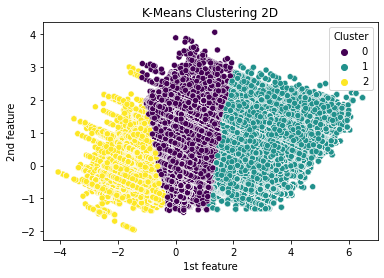

In [9]:
kmeans = KMeans(n_clusters=3,algorithm='auto',init='k-means++',max_iter=300)
kmeans.fit_predict(df_pca2)
labels = kmeans.labels_
df_pca2['Cluster'] = labels
sns.scatterplot(x=df_pca2['1st feature'], y=df_pca2['2nd feature'], hue='Cluster', data=df_pca2, palette='viridis')
plt.title('K-Means Clustering 2D')
plt.savefig('KMEANS_Clustering_2D_Simple.png', dpi=200) 

plt.show()

In [10]:
print("Explained Variance for Each Principal Component (PC=2):")
for i, var in enumerate(pca2.explained_variance_ratio_):
    print(f"PC{i + 1}: {var:.2%}")
    
    
loadings_df = pd.DataFrame(pca2.components_.T, columns=[f'PC{i+1}' for i in range(pca2.n_components_)], index=df[features3].columns)

print("Loadings for PC2:")
print(loadings_df[['PC1', 'PC2',]])


cluster_counts = Counter(labels)
percentages = {cluster: count / len(df) * 100 for cluster, count in cluster_counts.items()}
table_data = pd.DataFrame(list(percentages.items()), columns=['Cluster Label 2D', 'Percentage (%)'])
print(table_data)

Explained Variance for Each Principal Component (PC=2):
PC1: 67.17%
PC2: 13.03%
Loadings for PC2:
                    PC1       PC2
CPUTimeRAW     0.691185 -0.046488
ReqCPUS        0.100829  0.416695
AllocCPUS      0.100500  0.416593
ReqNodes       0.003097  0.009174
NNodes         0.006017  0.017755
total_minutes  0.590685 -0.463080
Timelimit_     0.389598  0.533560
ReqMem_MB      0.035431  0.388748
   Cluster Label 2D  Percentage (%)
0                 1       19.719141
1                 0       39.987186
2                 2       40.293673


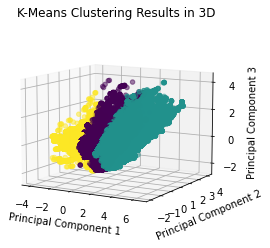

Explained Variance for Each Principal Component (PC=3):
PC1: 67.17%
PC2: 13.03%
PC3: 12.63%
Loadings for PC3:
                    PC1       PC2       PC3
CPUTimeRAW     0.691185 -0.046488  0.297456
ReqCPUS        0.100829  0.416695  0.280669
AllocCPUS      0.100500  0.416593  0.283571
ReqNodes       0.003097  0.009174  0.013853
NNodes         0.006017  0.017755  0.024448
total_minutes  0.590685 -0.463080  0.013884
Timelimit_     0.389598  0.533560 -0.736595
ReqMem_MB      0.035431  0.388748  0.456922
   Cluster Label 3D  Percentage (%)
0                 0       19.716314
1                 2       40.135326
2                 1       40.148360


In [11]:
kmeans = KMeans(n_clusters=3, algorithm='auto', init='k-means++', max_iter=300)
kmeans.fit_predict(df_pca3)
labels2 = kmeans.labels_
df_pca3['Cluster']=labels


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca3['1st feature'], df_pca3['2nd feature'], df_pca3['3rd feature'],
           c=df_pca3['Cluster'], cmap='viridis', alpha=0.5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('K-Means Clustering Results in 3D')
plt.savefig('KMEANS_Clustering_3D_Simple2.png', dpi=200)  
ax.view_init(elev=10, azim=-60)
plt.show()


print("Explained Variance for Each Principal Component (PC=3):")
for i, var in enumerate(pca3.explained_variance_ratio_):
    print(f"PC{i + 1}: {var:.2%}")
    
    
loadings_df = pd.DataFrame(pca3.components_.T, columns=[f'PC{i+1}' for i in range(pca3.n_components_)], index=df[features3].columns)

print("Loadings for PC3:")
print(loadings_df[['PC1', 'PC2','PC3']])


cluster_counts = Counter(labels2)
percentages = {cluster: count / len(df) * 100 for cluster, count in cluster_counts.items()}
table_data = pd.DataFrame(list(percentages.items()), columns=['Cluster Label 3D', 'Percentage (%)'])
print(table_data)

This is to try get more of understanding of how the features effected the clustering. This takes the data and uses the numerica features to try to predict the cluster label via a classification tree. The plot shown at the end will show which clusters were effected the most by the numeric features given, via a SHAP value. 

Note: The final plotted image is shown in the report, but this takes a very long time to load: ~20-30 minuted given the size of the dataframe

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Means (3D) clusters is 0.9959805296503047
[LightGBM] [Warning] Unknown parameter: colsample_by_tree


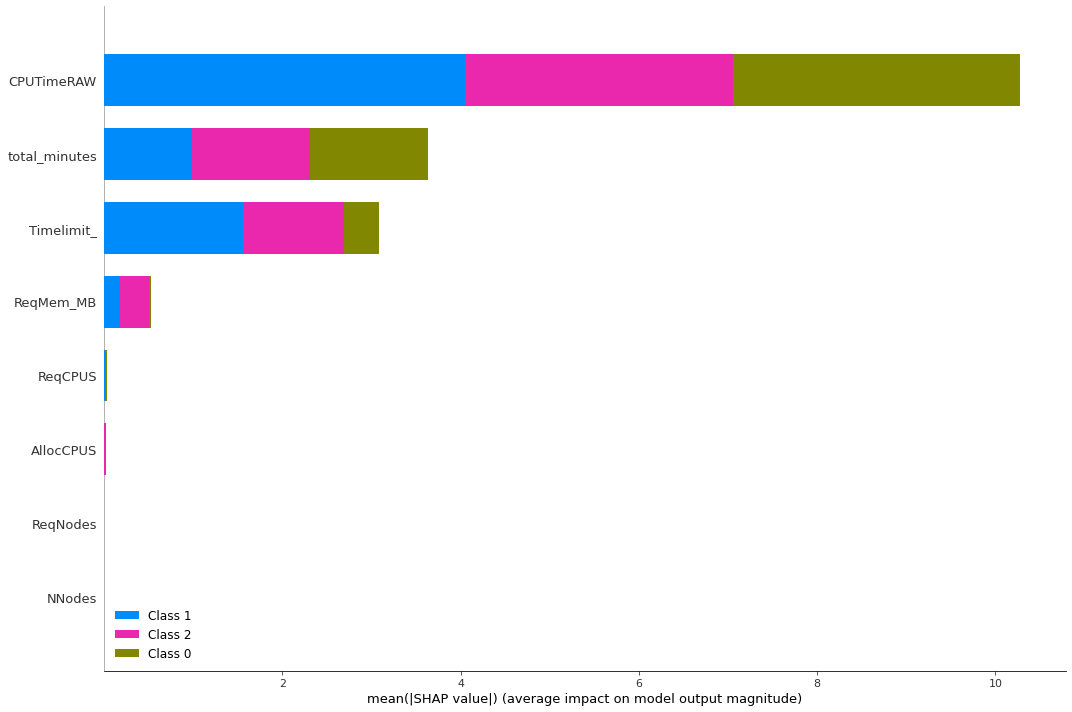

In [12]:
lgbm_data=df[features3]
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, labels2, scoring='f1_weighted')
print(f'CV F1 score for K-Means (3D) clusters is {np.mean(cv_scores_km)}')


clf_km.fit(lgbm_data, labels2)
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Means clusters (2D) is 0.9965203703085367
[LightGBM] [Warning] Unknown parameter: colsample_by_tree


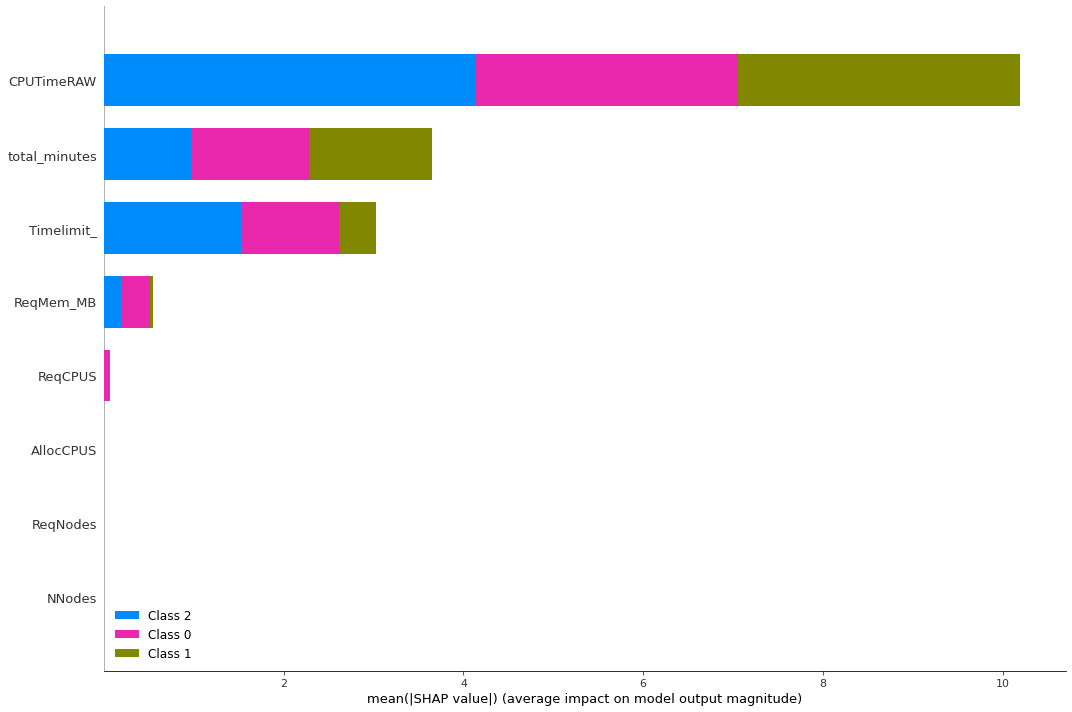

In [13]:
lgbm_data=df[features3]
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters (2D) is {np.mean(cv_scores_km)}')


clf_km.fit(lgbm_data, labels)
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

In [14]:
y=df['Group']
df_pca2['Group']=y
df_pca2 = df_pca2.drop(df_pca2.index[-1])
df_pca2

,1st feature,2nd feature,Cluster,Group
0,4.496051,0.778034,1,NaN
1,4.457472,0.793370,1,NaN
2,4.445893,0.797972,1,NaN
3,4.459311,0.792638,1,NaN
4,4.461650,0.791709,1,NaN
...,...,...,...,...
1449976,0.500355,0.089999,0,group_140
1449977,-0.339319,2.302176,0,group_140
1449978,0.566273,0.290256,0,group_140
1449979,2.818491,0.375392,1,group_140


These just give a break down of how the "Group" feature was allocated throughout the clustering. Because of how many unique groups are present in the SLURMS dataframe.

In [15]:
group_count_per_cluster = df_pca2.groupby(['Cluster', 'Group']).size().unstack(fill_value=0)
percentage_breakdown = group_count_per_cluster.div(group_count_per_cluster.sum(axis=1), axis=0) * 100
print(percentage_breakdown)

Group    group_000  group_001  group_002  group_003  group_004  group_005  \
Cluster                                                                     
0         2.283380   0.234558   4.559642   0.545553   0.297506   0.000375   
1         3.129869   0.098438   4.206488   0.575902   0.605356   0.003876   
2         2.689208   0.041334   4.951432   0.685322   0.462117   0.002893   

Group    group_006  group_007  group_008  group_009  ...  group_144  \
Cluster                                              ...              
0         0.000375   0.004871   2.414898   8.446709  ...   0.008243   
1         0.000775   0.005426   2.299733   6.635663  ...   0.000775   
2         0.000413   0.005373   2.013392  10.396396  ...   0.008680   

Group    group_145  group_146  group_147  group_148  group_149  group_150  \
Cluster                                                                     
0         0.008993   1.305431   0.001124   0.018735   0.004122   0.000749   
1         0.025578   0.6014